<a href="https://colab.research.google.com/github/luispc1989/MachineLearning/blob/main/assig_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Mount Google Drive
from google.colab import drive

def mount_google_drive():
    drive.mount('/content/drive')

In [ ]:
# Data Loading

def load_data(filepath):
    data = pd.read_csv(filepath, parse_dates=['date'], dayfirst=True)
    return data


In [ ]:
# Preprocessing

def preprocess_data(data):
    # Convert date to year-month format
    data['year_month'] = data['date'].dt.to_period('M')

    # Aggregate by month using median
    monthly_data = data.groupby('year_month').median().reset_index()

    # Convert 'year_month' back to datetime for plotting and indexing
    monthly_data['year_month'] = monthly_data['year_month'].dt.to_timestamp()
    return monthly_data

In [ ]:
# Feature Engineering (Lags)

def create_lag_features(df, n_lags=12):
    df_lagged = df.copy()
    for lag in range(1, n_lags + 1):
        for col in ['rainfall_mm', 'temperature_C', 'drainage_m3', 'river_hydrometry_m', 'depth_to_groundwater_m']:
            df_lagged[f'{col}_lag_{lag}'] = df_lagged[col].shift(lag)

    # Drop rows with NaN values due to lagging
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

In [ ]:
# Prepare Data for Model

def prepare_model_data(df):
    features = [col for col in df.columns if col.startswith(('rainfall', 'temperature', 'drainage', 'river_hydrometry', 'depth_to_groundwater')) and not col.endswith('_m')]
    target = 'depth_to_groundwater_m'
    groups = df['year_month'].dt.year * 12 + df['year_month'].dt.month  # Unique group per month

    X = df[features]
    y = df[target]
    return X, y, groups

In [ ]:
# Build Model Pipeline

def build_pipeline():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling
        ('model', RandomForestRegressor(random_state=42))  # Model
    ])
    return pipeline

In [ ]:
# Cross-Validation and Evaluation

def evaluate_model(pipeline, X, y, groups):
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(pipeline, X, y, cv=gkf, groups=groups, scoring='neg_root_mean_squared_error')
    print(f'Cross-validation RMSE scores: {-scores}')
    print(f'Mean CV RMSE: {-scores.mean():.4f}')
    return scores

In [ ]:
# Final Model Training and Plot

def plot_predictions(pipeline, X, y):
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.7, color='skyblue', edgecolors='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal fit')
    plt.xlabel('Actual Depth to Groundwater (m)')
    plt.ylabel('Predicted Depth to Groundwater (m)')
    plt.title('Actual vs. Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    rmse = mean_squared_error(y, y_pred) ** 0.5
    print(f'Final model RMSE on full data: {rmse:.4f}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,rainfall_mm,depth_to_groundwater_m,temperature_C,drainage_m3,river_hydrometry_m
0,2006-03-14,NaN,-22.18,NaN,NaN,NaN
1,2006-03-15,NaN,-22.14,NaN,NaN,NaN
2,2006-03-16,NaN,-22.04,NaN,NaN,NaN
3,2006-03-17,NaN,-22.04,NaN,NaN,NaN
4,2006-03-18,NaN,-22.04,NaN,NaN,NaN


Model input size: 63 features
Model output size: 1 target variable
Cross-validation RMSE scores: [0.73472441 0.80208176 0.75638764 0.71701887 0.59010932]
Mean CV RMSE: 0.7201


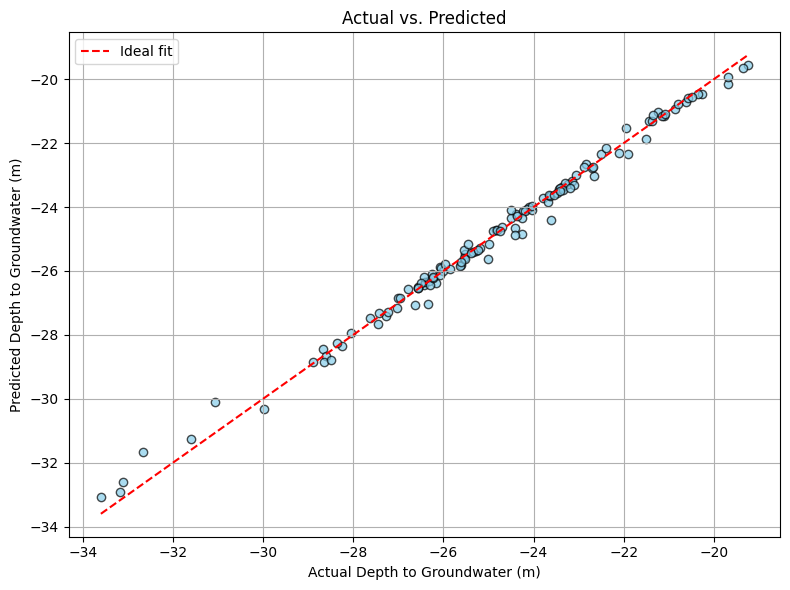

Final model RMSE on full data: 0.2524


In [ ]:
# Main Function - Model

def main():
    # Mount Google Drive
    mount_google_drive()

    # Define dataset path in Google Drive (correct path confirmed)
    filepath = '/content/drive/MyDrive/aquifer_time_series.csv'

    # Pipeline
    data = load_data(filepath)
    display(data.head())
    monthly_data = preprocess_data(data)
    lagged_data = create_lag_features(monthly_data)
    X, y, groups = prepare_model_data(lagged_data)

    print(f'Model input size: {X.shape[1]} features')
    print(f'Model output size: 1 target variable')

    pipeline = build_pipeline()

    # Evaluation
    evaluate_model(pipeline, X, y, groups)

    # Final training and prediction plot
    plot_predictions(pipeline, X, y)

if __name__ == '__main__':
    main()